In [6]:
# Import libraries
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import helper

In [7]:
# Load retention time data
tdata = pd.read_csv("../data/retention/retention.min.csv.gz")

In [8]:
# Data
p = 0.997
lvlcands = {}
for (lower, upper), d in tdata[(tdata["timept"] == 10000)].groupby(["lower","upper"]):
    lvlcand = d.mean()[["timept","lower","upper","width","successes","failures","reads","sets","resets","cycles","read_bits","set_bits","reset_bits","lvl","time"]].to_dict()
    lvl, cdf = sorted(d["lvl"].values), np.linspace(0.5/len(d), 1-0.5/len(d), len(d)) # symmetric percentile CDF (https://math.stackexchange.com/questions/33488/how-to-calculate-percentile-is-it-possible-to-get-100-percentile)
    lvlcand["lower_rd"] = int(np.floor(helper.intersection(np.array([0,64]), np.array([1-p,1-p]), np.array(lvl), cdf)[0][0]))
    lvlcand["upper_rd"] = int(np.ceil(helper.intersection(np.array([0,64]), np.array([p,p]), np.array(lvl), cdf)[0][0]))
    lvlcands[(int(lower), int(upper))] = lvlcand

In [9]:
# Digraph
DG = nx.DiGraph()
DG.add_nodes_from(lvlcands.items())
DG.add_edges_from([(cand1, cand2) for cand1 in lvlcands for cand2 in lvlcands if lvlcands[cand2]["lower_rd"] > lvlcands[cand1]["upper_rd"]])
DG.number_of_nodes(), DG.number_of_edges()

(797, 26848)

In [10]:
# Get all possible level allocations
allocations = []
for root in [(0,i) for i in range(64)]:
  for leaf in [(i,63) for i in range(64)]:
    try:
      for path in nx.all_simple_paths(DG, root, leaf):
        allocations.append(tuple(path))  
    except nx.NodeNotFound:
       pass
len(allocations)

7987

In [11]:
# Get all 1bpc allocations
allocations_bpc = {1 : [a for a in allocations if len(a) == 2], 2 : [a for a in allocations if len(a) == 4]}
allocations_bpc

{1: [((0, 7), (31, 63)),
  ((0, 7), (39, 63)),
  ((0, 7), (43, 63)),
  ((0, 7), (47, 63)),
  ((0, 7), (49, 63)),
  ((0, 7), (51, 63)),
  ((0, 7), (53, 63)),
  ((0, 7), (55, 63)),
  ((0, 7), (56, 63)),
  ((0, 7), (57, 63)),
  ((0, 7), (58, 63)),
  ((0, 7), (59, 63)),
  ((0, 7), (60, 63)),
  ((0, 7), (61, 63)),
  ((0, 7), (62, 63)),
  ((0, 7), (63, 63)),
  ((0, 8), (31, 63)),
  ((0, 8), (39, 63)),
  ((0, 8), (43, 63)),
  ((0, 8), (47, 63)),
  ((0, 8), (49, 63)),
  ((0, 8), (51, 63)),
  ((0, 8), (53, 63)),
  ((0, 8), (55, 63)),
  ((0, 8), (56, 63)),
  ((0, 8), (57, 63)),
  ((0, 8), (58, 63)),
  ((0, 8), (59, 63)),
  ((0, 8), (60, 63)),
  ((0, 8), (61, 63)),
  ((0, 8), (62, 63)),
  ((0, 8), (63, 63)),
  ((0, 10), (31, 63)),
  ((0, 10), (39, 63)),
  ((0, 10), (43, 63)),
  ((0, 10), (47, 63)),
  ((0, 10), (49, 63)),
  ((0, 10), (51, 63)),
  ((0, 10), (53, 63)),
  ((0, 10), (55, 63)),
  ((0, 10), (56, 63)),
  ((0, 10), (57, 63)),
  ((0, 10), (58, 63)),
  ((0, 10), (59, 63)),
  ((0, 10), (60, 

In [14]:
# Plot BW-BER tradeoff in level allocations
results = []
for bpc in range(1, 3):
    for a in allocations_bpc[bpc]:
        bws, confmat = [], []

        rdbounds = [0]
        for lvl1, lvl2 in zip(a[:-1], a[1:]):
            rdbounds.append(int((lvlcands[lvl1]["upper_rd"] + lvlcands[lvl2]["lower_rd"]) // 2))
        rdbounds.append(64)

        for i, lvl in enumerate(a):
            # Get the relevant data
            lvldata = tdata[(tdata["timept"] == 10000) & (tdata["lower"] == lvl[0]) & (tdata["upper"] == lvl[1])]

            # # DEBUG: plot distributions
            # plt.plot(sorted(lvldata["lvl"].values), np.linspace(0.5/len(lvldata["lvl"].values), 1-0.5/len(lvldata["lvl"].values), len(lvldata["lvl"].values)))

            # Compute bandwidth for level
            bw = 48 / (lvldata["cycles"].mean() * 1e-9)
            bws.append(bw)

            # Compute the CER for level
            confvec = [0] * 2**bpc
            for j, (rdbound_low, rdbound_high) in enumerate(zip(rdbounds[:-1], rdbounds[1:])):
                confvec[j] = len(lvldata[(lvldata["lvl"] > rdbound_low) & (lvldata["lvl"] <= rdbound_high)])
            confmat.append(confvec)
        confmat = np.array(confmat)

        # Compute overall results
        bw = sum(bws) / len(bws) * bpc

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER
        ber = (grayerr * confmat).sum() / confmat.sum()

        # CER
        cer = 1 - confmat.trace() / confmat.sum()

        # Results
        results.append([bpc, a, rdbounds, confmat, bw, ber, cer])
data = pd.DataFrame(results, columns=["bpc", "allocation", "read_bounds", "confmat", "bw", "ber", "cer"]).sort_values(["ber", "bw"], ascending=[True, False])
data.to_csv("../data/allocation/allocation.csv", index=False)
data

,bpc,allocation,read_bounds,confmat,bw,ber,cer
126,1,"((0, 32), (49, 63))","[0, 35, 64]","[[3028, 0], [0, 3034]]",7.750907e+07,0.000000,0.000000
128,1,"((0, 32), (53, 63))","[0, 37, 64]","[[3028, 0], [0, 3034]]",7.500132e+07,0.000000,0.000000
129,1,"((0, 32), (55, 63))","[0, 39, 64]","[[3028, 0], [0, 3034]]",7.393846e+07,0.000000,0.000000
131,1,"((0, 32), (57, 63))","[0, 40, 64]","[[3028, 0], [0, 3034]]",7.119608e+07,0.000000,0.000000
133,1,"((0, 32), (59, 63))","[0, 41, 64]","[[3028, 0], [0, 3034]]",6.980643e+07,0.000000,0.000000
...,...,...,...,...,...,...,...
3319,2,"((0, 20), (37, 43), (51, 59), (63, 63))","[0, 18, 42, 57, 64]","[[3024, 6, 0, 0], [8, 3018, 8, 0], [0, 6, 3020...",2.431295e+07,0.001726,0.003451
0,1,"((0, 7), (31, 63))","[0, 10, 64]","[[3007, 8], [3, 3031]]",3.993398e+07,0.001818,0.001818
124,1,"((0, 32), (43, 63))","[0, 30, 64]","[[3022, 6], [6, 3028]]",8.314429e+07,0.001980,0.001980
109,1,"((0, 24), (39, 63))","[0, 22, 64]","[[3025, 6], [8, 3026]]",6.342054e+07,0.002308,0.002308


In [20]:
# Get best allocations
data = pd.read_csv("../data/allocation/allocation.csv", converters={"allocation": eval, "read_bounds": eval})
best = data.groupby("bpc").first()
best

,Unnamed: 0,allocation,read_bounds,confmat,bw,ber,cer
bpc,,,,,,,
1,126,"((0, 32), (49, 63))","[0, 35, 64]",[[3028 0]\n [ 0 3034]],7.750907e+07,0.000000,0.000000
2,2274,"((0, 12), (36, 43), (53, 56), (62, 63))","[0, 14, 44, 56, 64]",[[3028 0 0 0]\n [ 0 3034 0 0]...,3.641239e+07,0.000041,0.000082


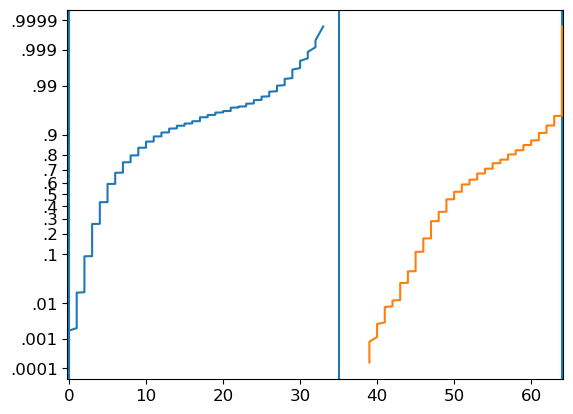

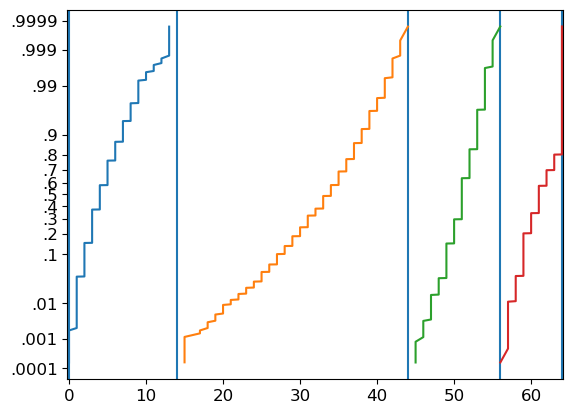

In [23]:
# Visualize allocations
for i, d in best.iterrows():
    plt.xlim(-0.2, 64.2)
    plt.gca().set_yscale("ppf")
    for bound in d["read_bounds"]:
        plt.axvline(bound)
    for lvl in d["allocation"]:
        # Get the relevant data
        lvldata = tdata[(tdata["timept"] == 10000) & (tdata["lower"] == lvl[0]) & (tdata["upper"] == lvl[1])]

        # DEBUG: plot distributions
        plt.plot(sorted(lvldata["lvl"].values), np.linspace(0.5/len(lvldata["lvl"].values), 1-0.5/len(lvldata["lvl"].values), len(lvldata["lvl"].values)))
    plt.show()

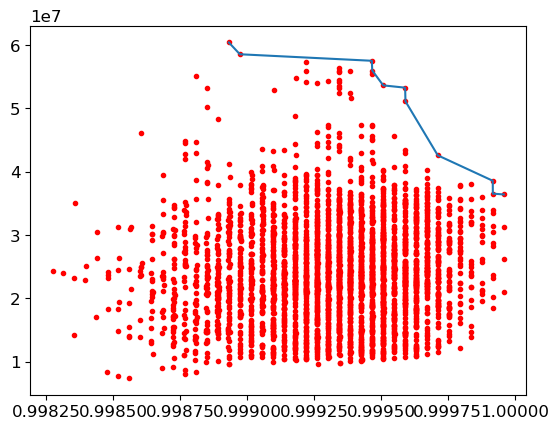

In [41]:
# Pareto curve
data["bacc"] = 1 - data["ber"]
data2 = data[data["bpc"] == 2]
plt.plot(data2["bacc"], data2["bw"], "r.")
costs = data2[["bacc", "bw"]].values
is_efficient = np.ones(costs.shape[0], dtype = bool)
for i, c in enumerate(costs):
    is_efficient[i] = np.all(np.any(costs[:i]<c, axis=1)) and np.all(np.any(costs[i+1:]<c, axis=1))
plt.plot(data2[is_efficient]["bacc"], data2[is_efficient]["bw"])
